In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import config
import numpy as np
import pandas as pd
import torch
from model import Model
from dataset import Dataset
from datasets import load_dataset
from pytorch_forecasting import TemporalFusionTransformer
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [ ]:
def plt_acc_bias(res):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax2 = ax.twinx()
    colors = ['tab:orange' if val >= 0 else 'tab:red' for val in res['bias']]
    res.plot(ax=ax, x='date', y='acc', kind='line', marker='o', color='tab:blue')
    res.plot(ax=ax2, x='date', y='bias', kind='bar', color=colors, alpha=0.6)
    ax.tick_params(axis='x', labelrotation=15)
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax.legend(lines, labels, loc='upper left') #, bbox_to_anchor=(1.05, 1), borderaxespad=0)
    ax2.legend_.remove()
    ax2.set_ylim(-(res.bias.abs().max()*1.2), (res.bias.abs().max()*1.2))
    # plt.tight_layout()
    plt.show()

In [ ]:
from matplotlib.ticker import FuncFormatter

def to_percent(y, position): 
    return f'{y * 100:.1f}%'

def plt_nulti(df, group='psd>=0', metric='wape', kind='line', save_name=None):
    df1 = df[df.group_type == group].groupby(['data_type', 'date']).mean().sort_values(['data_type'], ascending=[False])
    df_pivot = df1.reset_index().pivot(index='date', columns='data_type', values=metric)
    df_pivot = df_pivot[['TimesNet', 'ImputeFormer', 'iTransformer', 'DLinear', 'raw']]
    df_pivot.columns = ['TimesNet', 'ImputeFormer', 'iTransformer', 'DLinear', 'Raw Sales']
    fig, ax = plt.subplots(figsize=(10, 5))
    # plt.figure(figsize=(10, 6))

    bar_width = 0.16
    min_y, max_y = 10, -10
    index = np.arange(len(df_pivot.index))
    for i, column in enumerate(df_pivot.columns):
        if kind == 'bar':
            offset = (i - len(df_pivot.columns) / 2) * bar_width
            plt.bar(index + offset, df_pivot[column], width=bar_width, label=column)
        else:
            plt.plot(df_pivot.index, df_pivot[column], marker='o', label=column)
        min_y = min(df_pivot[column].min(), min_y)
        max_y = max(df_pivot[column].max(), max_y)

    ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
    if kind == 'line' and metric == 'wpe':
        ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
    if metric == 'wpe':
        ylim = max(abs(min_y), abs(max_y))
        plt.ylim(- ylim * 1.3, ylim * 1.3)
    plt.title(f'{metric.upper()} Over Time by Different Demand Recovery Method')
    # plt.xlabel('Date')
    plt.ylabel(metric.upper())
    plt.xticks(index, df_pivot.index, rotation=15)
    # ax.tick_params(axis='x', labelrotation=15)
    loc = 'upper left'
    # loc = 'lower left' if metric == 'wpe' else 'upper left'
    plt.legend(title='Demand Recovery Method', loc=loc)
    plt.tight_layout()
    if save_name != None:
        plt.savefig(save_name, format='eps', dpi=300, bbox_inches='tight')
        # fig.write_image(save_name, 
        #        engine="kaleido",
        #        format="svg")
    plt.show()

In [ ]:
config.date = '2025-07-14'
config.use_gpu = True
seq_len = config.dataset_config["max_encoder_length"] + config.dataset_config["max_prediction_length"]
his_start_date = datetime.strptime(config.date, '%Y-%m-%d') + timedelta(-seq_len)
his_start_date = his_start_date.strftime('%Y-%m-%d')

checkpoints_dir = 'checkpoints'

In [ ]:
def loadDataset(data_type='censored', data_path=None):
    t0 = time.time()
    dataset = load_dataset("Dingdong-Inc/FreshRetailNet-LT")
    df_train = dataset['train'].to_pandas()
    df_eval = dataset['eval'].to_pandas()

    df_train = df_train[df_train.dt >= his_start_date]
    df_train_psd = df_train.groupby(config.dataset_config['group_ids'])['sale_amount'].mean().to_frame('psd') # average daily sales amount
    df_eval = pd.merge(df_eval, df_train_psd, on = config.dataset_config['group_ids'])

    if data_type == 'recovered':
        df_train = pd.read_parquet(data_path)
        df_train = df_train[df_train.dt >= his_start_date]
        df_train['sale_amount'] = df_train['sale_amount_pred']

    df_eval_group_ids = df_eval[config.dataset_config['group_ids']].drop_duplicates()
    df_train = pd.merge(df_train, df_eval_group_ids, on = config.dataset_config['group_ids'])

    df = pd.concat([df_train, df_eval], ignore_index=True)
    df['day_of_week'] = df['dt'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d').weekday())
    df.loc[df.dt >= config.date, 'sale_amount'] = np.nan
    dataset = Dataset(df, config)
    t1 = time.time()
    print(f"dataset generation cost {t1-t0}")

    return dataset, df_train, df_eval

In [ ]:
target_dates = pd.date_range(start = config.date, periods = config.dataset_config["max_prediction_length"])
target_dates = [date.strftime("%Y-%m-%d") for date in target_dates]

def do_predict(dataset, model_path, df_eval, verbose=False):
    best_tft = TemporalFusionTransformer.load_from_checkpoint(model_path)

    t1 = time.time()
    res = best_tft.predict(dataset.predict_df, return_index=True)
    predictions, index = res.output[0].cpu(), res.index
    predictions[predictions < 0] = 0
    t2 = time.time()
    print(f"predict cost {t2-t1}") if verbose else None

    columns = target_dates + config.dataset_config["group_ids"]
    idx = np.array(index[config.dataset_config['group_ids']])
    preds = np.concatenate((predictions, idx), axis=1)
    preds = pd.DataFrame(preds, columns=columns)
    preds = preds.melt(id_vars=config.dataset_config['group_ids'],
                       value_vars=target_dates, var_name='dt', value_name='prediction')
    preds[['store_id', 'product_id']] = preds[['store_id', 'product_id']].astype(int)

    df_groudtruth = df_eval[['store_id', 'product_id', 'dt', 'sale_amount', 'stock_hour6_22_cnt', 'psd']]
    merged_df = pd.merge(df_groudtruth, preds, on = ['store_id', 'product_id', 'dt'])
    print(len(merged_df), len(merged_df) / config.dataset_config["max_prediction_length"]) if verbose else None

    return merged_df

def cal_metrics(df, data_type, groups=["psd>=0"]):
    sample_cnt, preds_sum, actuals_sum, preds_mean, actuals_mean  = {}, {}, {}, {}, {}
    acc, wape, wpe, mae, bias, mse = {}, {}, {}, {}, {}, {}
    res = pd.DataFrame()
    for group in groups:
        df1 = df.query(group)
        # target_dates = ['all_days']
        sub_res = pd.DataFrame(target_dates, columns=["date"])
        for target_date in target_dates:
            if len(target_dates) > 1:
                df2 = df1[(df1.dt == target_date) & (df1.stock_hour6_22_cnt == 0)]
            else:
                df2 = df1[(df1.stock_hour6_22_cnt == 0)]
            preds = df2.prediction
            actuals = df2.sale_amount
            sample_cnt[target_date] = len(df2)
            preds_sum[target_date] = preds.sum(axis=0)
            actuals_sum[target_date] = actuals.sum(axis=0)
            preds_mean[target_date] = preds.mean(axis=0)
            actuals_mean[target_date] = actuals.mean(axis=0)
            acc[target_date] = 1 - (preds - actuals).abs().sum(axis=0) / actuals.abs().sum(axis=0)
            wape[target_date] = (preds - actuals).abs().sum(axis=0) / actuals.abs().sum(axis=0)
            wpe[target_date] = (preds - actuals).sum(axis=0) / actuals.abs().sum(axis=0)
            mae[target_date] = (preds - actuals).abs().mean(axis=0)
            bias[target_date] = (preds - actuals).mean(axis=0)
            mse[target_date] = ((preds - actuals)**2).abs().mean(axis=0)

        sub_res['sample_cnt'] = sample_cnt.values()
        sub_res['preds_sum'] = preds_sum.values()
        sub_res['actuals_sum'] = actuals_sum.values()
        sub_res['preds_mean'] = preds_mean.values()
        sub_res['actuals_mean'] = actuals_mean.values()
        sub_res['acc'] = acc.values()
        sub_res['wape'] = wape.values()
        sub_res['wpe'] = wpe.values()
        sub_res['mae'] = mae.values()
        sub_res['bias'] = bias.values()
        sub_res['mse'] = mse.values()
        sub_res.insert(0, 'data_type', data_type)
        sub_res.insert(0, 'group_type', group)
        res = pd.concat([res, sub_res], ignore_index=True)
    return res

def get_sorted_files(directory='.'):
    files = [
        f for f in os.listdir(directory)
        if os.path.isfile(os.path.join(directory, f))
    ]
    sorted_files = sorted(files)
    return sorted_files

def get_pred(dataset, df_eval, data_type, start_epoch=0, verbose=False):
    model_dir = f"./lightning_logs/{data_type}/{checkpoints_dir}"
    print(model_dir)
    files = get_sorted_files(model_dir)
    df_pred = []
    for idx, file in enumerate(files):
        epoch_num = file.split('-')[0].split('=')[1]
        if start_epoch == -1:
            if idx + 1 == len(files):
                _data_type = f"{data_type}_epoch{epoch_num}"
                print(_data_type)
                df_pred.append((_data_type, do_predict(dataset, os.path.join(model_dir, file), df_eval, verbose)))
        else:
            if int(epoch_num) >= start_epoch:
                _data_type = f"{data_type}_epoch{epoch_num}"
                print(_data_type)
                df_pred.append((_data_type, do_predict(dataset, os.path.join(model_dir, file), df_eval, verbose)))
    if len(df_pred) > 1:
        pred_cols = [df['prediction'] for (data_type, df) in df_pred[-3:]]
        df_avg = df_pred[0][1].copy()
        df_avg['prediction'] = pd.concat(pred_cols, axis=1).mean(axis=1)
        _data_type = f"{data_type}_epochAvg"
        df_pred.append((_data_type, df_avg))
    return df_pred

def get_metrics(df_pred, groups=["psd>=0"]):
    df_res = pd.DataFrame()
    for (data_type, df) in df_pred:
        df_ = cal_metrics(df, data_type, groups)
        df_res = pd.concat([df_res, df_], axis=0, ignore_index=True)
    return df_res

In [ ]:
dataset_types = [
    ('raw', 'censored', 'checkpoints_250720_7_10pt_lrv2'),
    ('TimesNet', 'recovered', 'checkpoints_250720_7_10pt_TimesNet_lrv2'),
    ('ImputeFormer', 'recovered', 'checkpoints_250720_7_10pt_ImputeFormer_lrv2'),
    ('iTransformer', 'recovered', 'checkpoints_250720_7_10pt_iTransformer_lrv2'),
    ('DLinear', 'recovered', 'checkpoints_250720_7_10pt_DLinear_lrv2')
]
dataset_dict = {}
dataset_dict['raw'], df_train, df_eval = loadDataset('censored')
dataset_dict['TimesNet'], df_train, df_eval = loadDataset('recovered', '../../latent_demand_recovery/exp/demand/TimesNet_demand.parquet')
dataset_dict['ImputeFormer'], df_train, df_eval = loadDataset('recovered', '../../latent_demand_recovery/exp/demand/ImputeFormer_demand.parquet')
dataset_dict['iTransformer'], df_train, df_eval = loadDataset('recovered', '../../latent_demand_recovery/exp/demand/iTransformer_demand.parquet')
dataset_dict['DLinear'], df_train, df_eval = loadDataset('recovered', '../../latent_demand_recovery/exp/demand/DLinear_demand.parquet')

In [ ]:
total_pred = []
for (a, b, c) in dataset_types:
    checkpoints_dir = c
    df_pred = get_pred(dataset_dict[a], df_eval, b, start_epoch=-1, verbose=True)
    for (_data_type, _pred) in df_pred:
        _data_type = a + '_' + _data_type
        if len(df_pred) == 1:
            _data_type = a
        total_pred.append((_data_type, _pred))

In [ ]:
total_res = get_metrics(total_pred)
total_res.groupby(['data_type', 'date']).mean().sort_values(['data_type', 'date'], ascending=[False, True])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


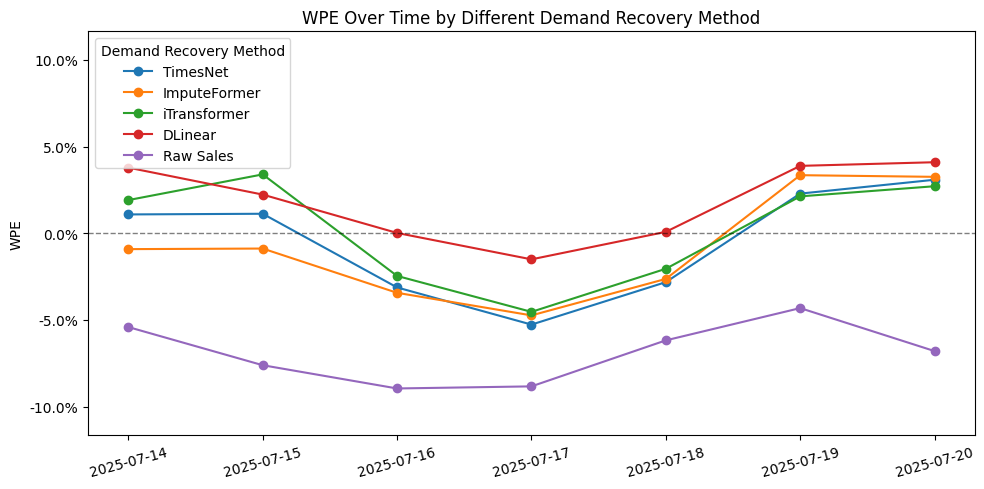

In [46]:
plt_nulti(total_res, group='psd>=0', metric='wpe', save_name='tft_wpe_line_chart.eps')

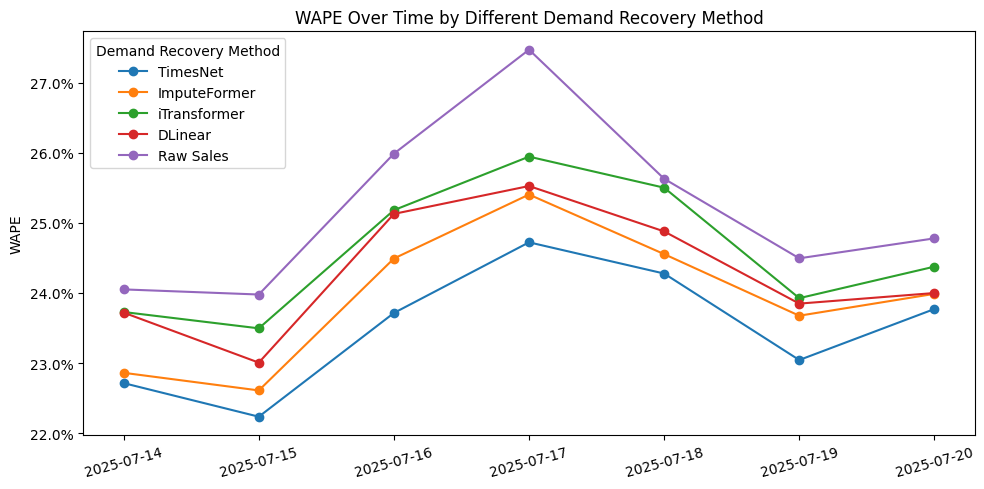

In [47]:
plt_nulti(total_res, group='psd>=0', metric='wape')